In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#columns = model_name,personality_1,personality_2,agent_1_scores,agent_2_scores,agent_1_messages,agent_2_messages,agent_1_actions,agent_2_actions,total_rounds
csv_path = "/cluster/home/mlindner/Github/master_thesis_project/src/data/outputs/experiment_250225.csv"
df = pd.read_csv(csv_path, converters={
    'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'total_rounds': int
})

df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

## plot the final scores of each agent of each game

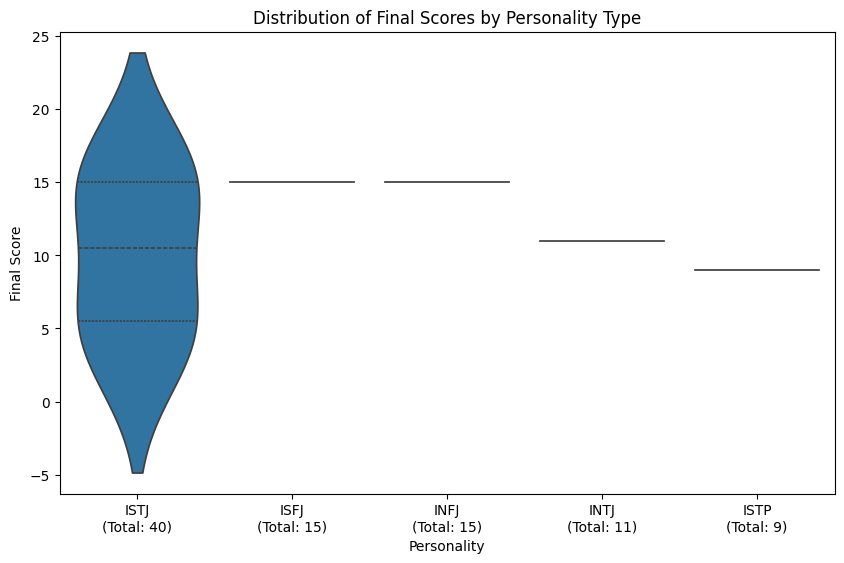

In [16]:
# Extract the final scores and personality types
final_scores = []
for i, row in df.iterrows():
    final_scores.append({'Personality': row['personality_1'], 'Final Score': row['agent_1_cumulative_scores'][-1]})
    final_scores.append({'Personality': row['personality_2'], 'Final Score': row['agent_2_cumulative_scores'][-1]})

# Create a DataFrame from the final scores
final_scores_df = pd.DataFrame(final_scores)

# Calculate total scores across all games for each personality
total_scores = final_scores_df.groupby('Personality')['Final Score'].sum().reset_index()
total_scores_dict = total_scores.set_index('Personality')['Final Score'].to_dict()

# Plot the distribution of final scores by personality type using violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile')
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n(Total: {total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

## plot all cumulative scores against eachother

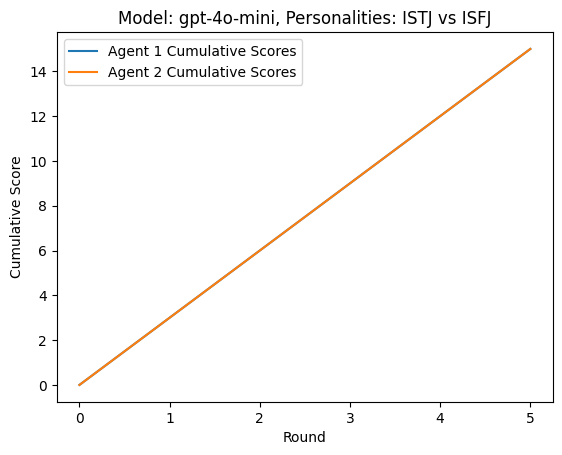

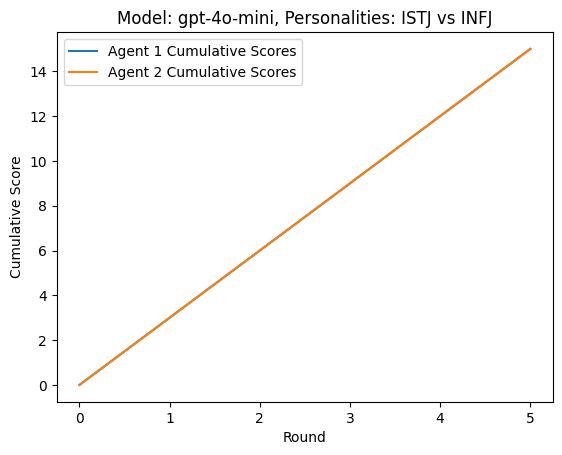

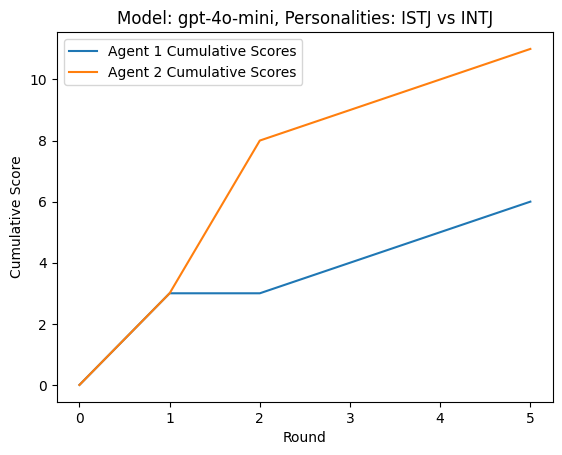

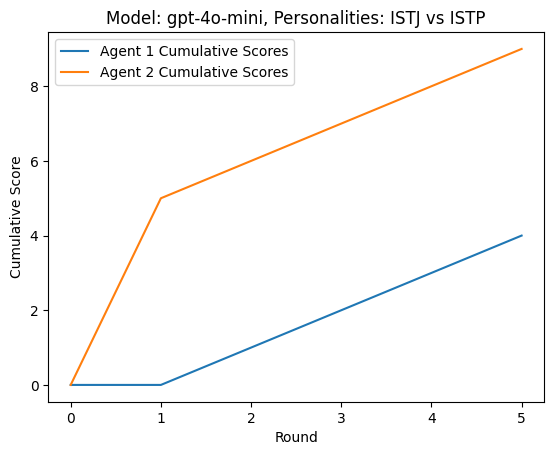

In [4]:
for i, row in df.iterrows():
    plt.figure()
    agent_1_scores = row['agent_1_cumulative_scores']
    agent_2_scores = row['agent_2_cumulative_scores']
    plt.plot(range(len(agent_1_scores)), agent_1_scores, label='Agent 1 Cumulative Scores')
    plt.plot(range(len(agent_2_scores)), agent_2_scores, label='Agent 2 Cumulative Scores')
    plt.title(f"Model: {row['model_name']}, Personalities: {row['personality_1']} vs {row['personality_2']}")
    plt.xlabel('Round')
    plt.ylabel('Cumulative Score')
    plt.legend()
    plt.show()

## plot mean cummulative scores

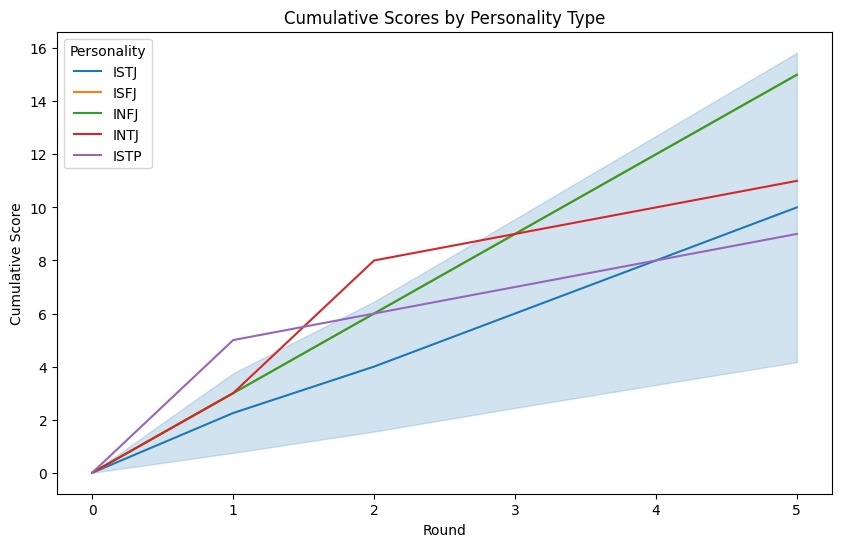

In [13]:
# Prepare the data for plotting
plot_data = []

for i, row in df.iterrows():
    for round_num, score in enumerate(row['agent_1_cumulative_scores']):
        plot_data.append({'Round': round_num, 'Cumulative Score': score, 'Personality': row['personality_1']})
    for round_num, score in enumerate(row['agent_2_cumulative_scores']):
        plot_data.append({'Round': round_num, 'Cumulative Score': score, 'Personality': row['personality_2']})

plot_df = pd.DataFrame(plot_data)

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='Round', y='Cumulative Score', hue='Personality', errorbar='sd')
plt.title('Cumulative Scores by Personality Type')
plt.xlabel('Round')
plt.ylabel('Cumulative Score')
plt.legend(title='Personality')
plt.show()